# Load Forecasting
### 1. Data manipulation

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read processed load data
base_dir = os.getcwd()
load_file_path = os.path.join(base_dir, 'processed_load_data.csv')
data = pd.read_csv(load_file_path)
print(data.head())

# Read processed temperature data
temp_file_path = os.path.join(base_dir, 'weighted_avg_temp.csv')
avg_temp_data = pd.read_csv(temp_file_path)
print(avg_temp_data.head())


                       Time (CET/CEST)  \
0  01.01.2015 00:00 - 01.01.2015 01:00   
1  01.01.2015 01:00 - 01.01.2015 02:00   
2  01.01.2015 02:00 - 01.01.2015 03:00   
3  01.01.2015 03:00 - 01.01.2015 04:00   
4  01.01.2015 04:00 - 01.01.2015 05:00   

   Day-ahead Total Load Forecast [MW] - BZN|SE4  \
0                                        2754.0   
1                                        2718.0   
2                                        2660.0   
3                                        2606.0   
4                                        2600.0   

   Actual Total Load [MW] - BZN|SE4  
0                            2343.0  
1                            2267.0  
2                            2281.0  
3                            2313.0  
4                            2372.0  
             Timestamp  weighted_avg
0  2015-01-01 00:00:00      4.451320
1  2015-01-01 01:00:00      4.217264
2  2015-01-01 02:00:00      4.302403
3  2015-01-01 03:00:00      4.207889
4  2015-01-01 04:00:00     

In this section we implement the machine learning models. We start with our benchmark model which will later be used to compare the reaults of our 'advanced' models.

component            Actual Total Load [MW] - BZN|SE4
Timestamp                                            
2025-01-01 00:00:00                            2325.0
2025-01-01 01:00:00                            2214.0
2025-01-01 02:00:00                            2102.0
2025-01-01 03:00:00                            2115.0
2025-01-01 04:00:00                            2250.0
2025-01-01 05:00:00                            2337.0


<Axes: xlabel='Timestamp'>

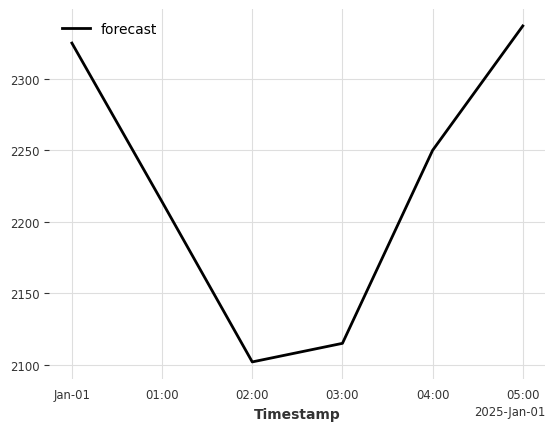

In [ ]:
from darts.models import NaiveSeasonal
from darts import TimeSeries

filepath = os.path.join("LoadData", "total_loadUTC_data.csv")
data = pd.read_csv(filepath)
data = pd.read_csv(filepath)

# Extract start timestamp (from "01.01.2015 00:00 - 01.01.2015 01:00")
data['Timestamp'] = pd.to_datetime(
    data['Time (UTC)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
)

# Set timestamp as index
data.set_index('Timestamp', inplace=True)

# Select one target column only (univariate series)
forecast_data = data['Actual Total Load [MW] - BZN|SE4']

# Create TimeSeries object
series = TimeSeries.from_series(forecast_data)

model = NaiveSeasonal(K=24)
model.fit(series)
pred = model.predict(6) # change this to number of hours to be plotted
print(pred.pd_dataframe())
pred.plot(label="forecast")